In [1]:
from collections import defaultdict
import csv 

import pdb
import gensim
from gensim import matutils, corpora
from gensim.models.ldamodel import LdaModel
import pandas as pd
import nltk
import statsmodels 
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import numpy as np

import snowball

In [2]:
# all data
tweet_data = pd.read_csv("CancerReport-clean-all-data-en.txt", delimiter="\t", low_memory=False)

In [3]:
# pull out just the retweets
retweets = tweet_data[tweet_data["retweet"] == True]
unique_retweet_id_list = list(set(retweets["retweet_id_str"].tolist()))

In [4]:
# group the tweets by the tweet they are, erm, retweeting
grouped_retweets = retweets.groupby("retweet_id_str")
# then count up retweets and extract original (retweeted) text
# see code in snowball.py for doing this
orig_tweet_texts, retweet_counts = snowball._count_up_retweets(grouped_retweets)

In [5]:
# primary tweets (non-retweets)
primary_tweets = tweet_data[tweet_data["retweet"] == False]
# now merge tweet sets (retweeted and not)
orig_tweet_texts.extend(primary_tweets["tweet_text"].values)
retweet_counts.extend([0]*primary_tweets.shape[0])
f = lambda x : x if x <= 25 else 26
clipped_retweet_counts = [f(n) for n in retweet_counts]

[(0, 26)]

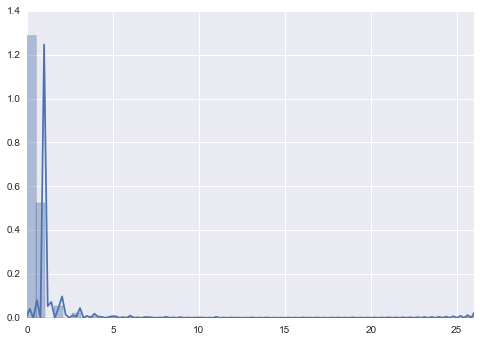

In [6]:
sns.distplot(clipped_retweet_counts).set(xlim=(0, 26))

[(0, 26)]

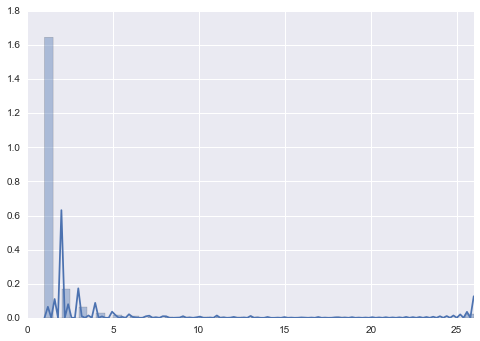

In [9]:
plt.clf()
sns.distplot([n for n in clipped_retweet_counts if n>0]).set(xlim=(0, 26))

In [10]:
### 
# now topic modeling
###

# kept_indices are the set of indices corresponding to tweets not discarded as noise 
toked_tweets, kept_indices = snowball.build_gensim_corpus(orig_tweet_texts, split_up_by_tag=False)
lda, gensim_corpus, dict_ = snowball.gen_lda_model(toked_tweets)
inferred_topic_matrix = lda.inference(gensim_corpus)[0]
# renorm, due to weirdness in gensim (???)
row_sums = inferred_topic_matrix.sum(axis=1)
inferred_topic_matrix = inferred_topic_matrix / row_sums[:, np.newaxis]

# remove the tweets that were cleaned/not included in gensim corpus
retweet_counts = [retweet_counts[idx] for idx in kept_indices]
orig_tweet_texts = [orig_tweet_texts[idx] for idx in kept_indices]


In [11]:
###
# and now regress retweet counts on inferred topic distributions (per tweet)
###

# this is just ordinary least squares (OLS)
regression_results = sm.OLS(retweet_counts, inferred_topic_matrix).fit()
print(regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.119
Date:                Wed, 16 Dec 2015   Prob (F-statistic):           1.20e-08
Time:                        14:45:17   Log-Likelihood:            -1.9505e+05
No. Observations:               43954   AIC:                         3.901e+05
Df Residuals:                   43944   BIC:                         3.902e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             1.7405      0.680      2.558      0.0

In [12]:
for topic_idx, topic in enumerate(lda.print_topics()):
    print("topic %s:\n %s\n" % (topic_idx+1, topic))

topic 1:
 0.073*co + 0.068*http + 0.034*ecrchat + 0.022*gt + 0.014*phdchat + 0.012*shop + 0.011*ji + 0.011*amp + 0.008*research + 0.008*im

topic 2:
 0.115*mcrcomeback + 0.077*msg + 0.052*gurmeetramrahim + 0.011*nedcrc + 0.010*un + 0.009*wow + 0.008*ur + 0.007*action + 0.007*amazing + 0.007*pita

topic 3:
 0.075*co + 0.066*http + 0.055*cancer + 0.038*mammograms + 0.025*women + 0.021*breast + 0.020*free + 0.020*mammogram + 0.016*cervical + 0.013*https

topic 4:
 0.073*colonoscopy + 0.065*co + 0.060*http + 0.025*fightcancer + 0.014*mammogram + 0.014*get + 0.008*time + 0.008*today + 0.007*getting + 0.007*think

topic 5:
 0.060*pap + 0.039*smear + 0.024*crclub + 0.019*imusicrcti + 0.018*imusic_rcti + 0.017*hpv + 0.017*test + 0.016*kotakmisteriimusic + 0.016*get + 0.013*mammogram

topic 6:
 0.015*est + 0.014*loscrcl + 0.012*oh + 0.011*control + 0.011*likely + 0.011*penalty + 0.011*icrc + 0.010*birth + 0.009*less + 0.009*pap

topic 7:
 0.056*nedvscrc + 0.028*worldcup + 0.023*costa + 0.021*ri

In [14]:
top_topic_tweet_indices = inferred_topic_matrix[:,3].argsort()[-20:]
print("\n\n".join([orig_tweet_texts[idx] for idx in top_topic_tweet_indices]))

Great to see such support for Relay for Life, you go @morrison954 #fightcancer

Methods of bowel preparation for colonoscopy - Helium http://t.co/VwJxDbMY

And I got called back for more pictures. Nothing to worry about, right? #mammogramfun

Let's show our support to this warrior #EdwardObiero ...#FightCancer  http://t.co/mOVz1aIxkc http://t.co/SeeCgZLD39

i think i would rather look at your colonoscopy pics than your facebook page.

@DelphiRunning relay for life tonight! Let's see the runners here tonight! :) #raisingmoney #fightcancer #delphirunning

“@Madithecanadian: Aw I made cookies for my homeroom tomorrow. #mathcrctspirit http://t.co/SRTa21pSSN” I LOVE YOU MADISON.

Korey's Gardasil Story: If I could turn back time http://t.co/QtMp4LQIF8

I'd rather have a back to back mammogram and colonoscopy than go into work today.

Happy to get to sing for a good cause again #FightCancer #vinterlyd http://t.co/L8hDptRUmL

This Sunday is FITNESS for HOPE for @cityofhope!  We're on @PhillyT